In [1]:
# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc
)

In [2]:
# --- Step 2: Load Dataset ---
df = pd.read_csv("C:/Users/DELL/Desktop/MSc/1st Sem/AML/Loan_Default - Copy.csv")

In [3]:
# Drop identifier column if exists
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

In [4]:
# --- Step 3: Data Exploration ---
print(df.head())
print(df.info())

   year loan_limit             Gender approv_in_adv loan_type loan_purpose  \
0  2019         cf  Sex Not Available         nopre     type1           p1   
1  2019         cf               Male         nopre     type2           p1   
2  2019         cf               Male           pre     type1           p1   
3  2019         cf               Male         nopre     type1           p4   
4  2019         cf              Joint           pre     type1           p1   

  Credit_Worthiness open_credit business_or_commercial  loan_amount  ...  \
0                l1        nopc                  nob/c       116500  ...   
1                l1        nopc                    b/c       206500  ...   
2                l1        nopc                  nob/c       406500  ...   
3                l1        nopc                  nob/c       456500  ...   
4                l1        nopc                  nob/c       696500  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0        

In [5]:
# Missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 loan_limit                    1109
approv_in_adv                  277
loan_purpose                    38
rate_of_interest             12209
Interest_rate_spread         12281
Upfront_charges              13287
term                            16
Neg_ammortization               40
property_value                5104
income                        3008
age                             72
submission_of_application       72
LTV                           5104
dtir1                         8072
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_16892\3176283813.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Status", data=df, palette="coolwarm")


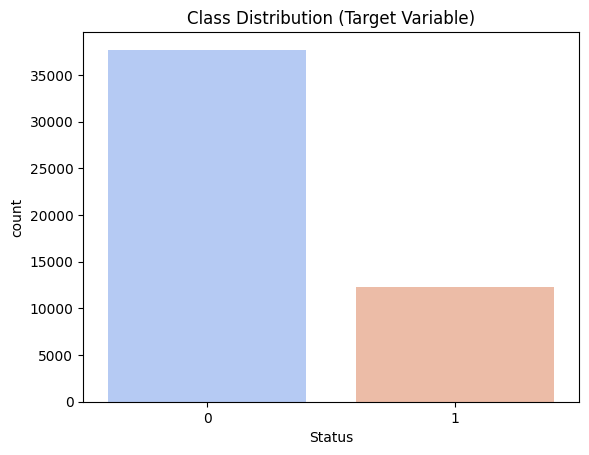

In [6]:
# Target distribution
sns.countplot(x="Status", data=df, palette="coolwarm")
plt.title("Class Distribution (Target Variable)")
plt.show()

In [ ]:
# --- Step 4: Pre-Processing ---
# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Impute numeric with median
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical with mode
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# One-hot encode categoricals
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded_array = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols), index=df.index)

In [8]:
# Define X and y
X = pd.concat([df[num_cols].drop("Status", axis=1, errors="ignore"), encoded_df], axis=1)
y = df["Status"]

In [9]:
# --- Step 5: Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:

# Balance train data with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", pd.Series(y_train_res).value_counts())

After SMOTE: Status
0.0    30174
1.0    30174
Name: count, dtype: int64


In [11]:
# --- Step 6a: Baseline Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)

print("Baseline Random Forest Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Baseline Random Forest Results:
[[7544    0]
 [   0 2456]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7544
         1.0       1.00      1.00      1.00      2456

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [12]:
# --- Step 6b: Hyperparameter Tuning (RandomizedSearchCV) ---
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20, cv=3, scoring="f1", n_jobs=-1, random_state=42, verbose=2
)
rf_search.fit(X_train_res, y_train_res)

print("Best Parameters:", rf_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}


In [13]:
# Final tuned model
best_rf = rf_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest Results:")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Tuned Random Forest Results:
[[7544    0]
 [   0 2456]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7544
         1.0       1.00      1.00      1.00      2456

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



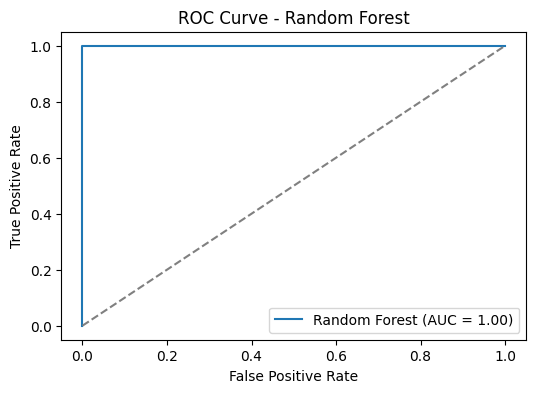

In [14]:
# --- Step 7: ROC Curve ---
y_proba = best_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16892\1368953742.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="coolwarm")


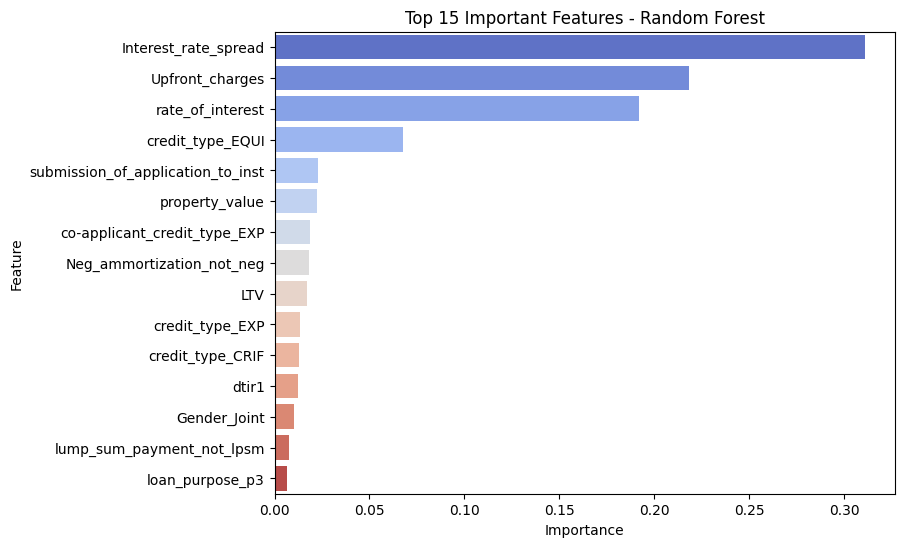

In [15]:
# --- Step 8: Feature Importance ---
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="coolwarm")
plt.title("Top 15 Important Features - Random Forest")
plt.show()

In [ ]:
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# 1. Shuffled Target Test
def shuffled_target_test(model, X_train, y_train, X_test, y_test):
    y_shuffled = np.random.permutation(y_train)
    model.fit(X_train, y_shuffled)
    acc = model.score(X_test, y_test)
    print(f"Accuracy with shuffled target: {acc:.4f}")

Accuracy with shuffled target: 0.7544


In [16]:
from sklearn.model_selection import cross_val_score, learning_curve

# --- Cross-validation ---
model =RandomForestClassifier(random_state=42, max_depth=5)  
scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.9977     0.9878     0.9975     0.9937     0.99819982]
Mean accuracy: 0.9949799639963997


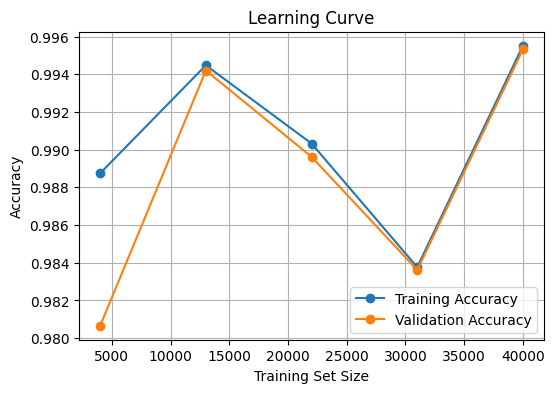

In [17]:
# --- Learning curve ---
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
plt.plot(train_sizes, val_mean, 'o-', label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()